In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import openpyxl

In [4]:
df = pd.read_excel('DSSToxQuery_20231117_REACH.xlsx', index_col=[0])
df.head()

/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Found_By,DSSTox_Substance_Id,DSSTox_Structure_Id,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,Structure_SMILES,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,Structure_SMILES_2D-QSAR,DateModified
Query,,,,,,,,,,,,,,,
50-45-3,CAS-RN matched <b>null</b>,DTXSID5024976,DTXCID704976,DSSTox_High,"2,3-Dichlorobenzoic acid",50-45-3,Single Compound,"Benzoic acid, 2,3-dichloro-\n",OC(=O)C1=CC=CC(Cl)=C1Cl,InChI=1S/C7H4Cl2O2/c8-5-3-1-2-4(6(5)9)7(10)11/...,QAOJBHRZQQDFHA-UHFFFAOYSA-N,C7H4Cl2O2,191.010,OC(=O)C1=CC=CC(Cl)=C1Cl,20210719.0
50-48-6,CAS-RN matched <b>null</b>,DTXSID7022594,DTXCID502594,DSSTox_High,Amitriptyline,50-48-6,Single Compound,NaN,CN(C)CCC=C1C2=CC=CC=C2CCC2=C1C=CC=C2,InChI=1S/C20H23N/c1-21(2)15-7-12-20-18-10-5-3-...,KRMDCWKBEZIMAB-UHFFFAOYSA-N,C20H23N,277.411,CN(C)CCC=C1C2=CC=CC=C2CCC2=C1C=CC=C2,20230406.0
50-85-1,CAS-RN matched <b>null</b>,DTXSID30198166,DTXCID60120657,Public_High_CAS,m-Cresotic acid,50-85-1,Single Compound,Loaded based on no conflicts with this data in...,CC1=CC(O)=C(C=C1)C(O)=O,InChI=1S/C8H8O3/c1-5-2-3-6(8(10)11)7(9)4-5/h2-...,NJESAXZANHETJV-UHFFFAOYSA-N,C8H8O3,152.149,CC1=CC(O)=C(C=C1)C(O)=O,20210723.0
51-03-6,CAS-RN matched <b>null</b>,DTXSID1021166,DTXCID501166,DSSTox_High,Piperonyl butoxide,51-03-6,Single Compound,NaN,CCCCOCCOCCOCC1=CC2=C(OCO2)C=C1CCC,InChI=1S/C19H30O5/c1-3-5-7-20-8-9-21-10-11-22-...,FIPWRIJSWJWJAI-UHFFFAOYSA-N,C19H30O5,338.444,CCCCOCCOCCOCC1=CC2=C(OCO2)C=C1CCC,20231110.0
51-17-2,CAS-RN matched <b>null</b>,DTXSID8024573,DTXCID704573,DSSTox_High,Benzimidazole,51-17-2,Single Compound,NaN,N1C=NC2=C1C=CC=C2,"InChI=1S/C7H6N2/c1-2-4-7-6(3-1)8-5-9-7/h1-5H,(...",HYZJCKYKOHLVJF-UHFFFAOYSA-N,C7H6N2,118.139,N1C=NC2=C1C=CC=C2,20210519.0


In [5]:
reach_prs = pd.read_csv('reach_pairs.csv', index_col = [0])

In [6]:
reach_prs = reach_prs[['source_DSSTox_Substance_Id', 'source_Substance_Name','source_Structure_SMILES',
       'source_Structure_InChIKey', 'source_qsarsmi', 
       'source_Structure_Formula', 'source_Structure_MolWt','target_DSSTox_Substance_Id',
       'target_Substance_Name', 
       'target_Structure_SMILES',  'target_Structure_Formula',
       'target_Structure_MolWt','target_Structure_InChIKey',
       'target_qsarsmi']]

In [7]:
reach_prs = reach_prs[(reach_prs['target_qsarsmi'].notnull()) & (reach_prs['source_qsarsmi'].notnull()) ]

In [8]:
targets = reach_prs[['target_DSSTox_Substance_Id', 'target_qsarsmi']]

In [18]:
targets_fp = mkfp(targets, name = 'target_DSSTox_Substance_Id', smi = 'target_qsarsmi')

In [13]:
import numpy as np

In [14]:
def mkfp(df, name, smi):
    MOLS = dict(zip(df[name], df[smi]))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
    FP.index=MOLS.keys()
    FP.columns = ['mrgn_%d'%i for i in FP.columns]
    return FP

In [15]:
echa = mkfp(df[df['Structure_SMILES'].notnull()], 'DSSTox_Substance_Id', 'Structure_SMILES')

[16:22:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:22:37] Explicit valence for atom # 3 Si, 8, is greater than permitted
[16:22:37] WARNING: not removing hydrogen atom without neighbors
[16:22:37] Explicit valence for atom # 31 N, 4, is greater than permitted
[16:22:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:22:37] WARNING: not removing hydrogen atom without neighbors
[16:22:37] Explicit valence for atom # 9 Al, 8, is greater than permitted
[16:22:37] WARNING: not removing hydrogen atom without neighbors
[16:22:37] WARNING: not removing hydrogen atom without neighbors
[16:22:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:22:37] Can't kekulize mol.  Unkekulized atoms: 7 8 10 12 13
[16:22:37] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12
[16:22:37] Explicit valence for atom # 3 O, 3, is greater than permitted
[16:22:37] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:22:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:22:37] 

In [74]:
echa_ids = echa.index.tolist()

In [76]:
df_1 = df[df['DSSTox_Substance_Id'].isin(echa_ids)]

In [82]:
df_1 = df_1[['DSSTox_Substance_Id', 'Structure_SMILES']].reset_index()[['DSSTox_Substance_Id', 'Structure_SMILES']]

In [83]:
df_1.columns = ['dtxsid', 'smi']

In [84]:
targets.columns = ['dtxsid', 'smi']

In [87]:
df_2 = pd.concat([df_1, targets], axis = 0)

In [88]:
smi_dict = {k:v for k,v in zip(df_2['dtxsid'], df_2['smi'])}

In [90]:
#smi_dict

In [19]:
all_df = pd.concat([echa, targets_fp])

In [20]:
all_df = all_df[~all_df.index.duplicated(keep='first')] 

In [22]:
#all_df

In [23]:
from scipy.spatial.distance import pdist, squareform

D_mgrn = pd.DataFrame(squareform(pdist(all_df, 'jaccard')), columns = all_df.index, index = all_df.index)
S_mgrn = 1-D_mgrn
S_mgrn.head()

,DTXSID5024976,DTXSID7022594,DTXSID30198166,DTXSID1021166,DTXSID8024573,DTXSID0020523,DTXSID4024981,DTXSID2043874,DTXSID4049038,DTXSID6035106,...,DTXSID2021947,DTXSID6022977,DTXSID5052250,DTXSID1040112,DTXSID1027267,DTXSID1047609,DTXSID6040111,DTXSID4042206,DTXSID501104446,DTXSID5038830
DTXSID5024976,1.000000,0.065574,0.232558,0.042254,0.081633,0.100000,0.236842,0.088889,0.063830,0.105263,...,0.023256,0.102564,0.066667,0.060000,0.000000,0.037736,0.069767,0.070175,0.043478,0.140351
DTXSID7022594,0.065574,1.000000,0.064516,0.074074,0.100000,0.062500,0.034483,0.087719,0.032787,0.018519,...,0.036364,0.056604,0.054795,0.031250,0.041667,0.079365,0.053571,0.072464,0.068627,0.114286
DTXSID30198166,0.232558,0.064516,1.000000,0.056338,0.058824,0.191489,0.200000,0.111111,0.085106,0.102564,...,0.046512,0.100000,0.101695,0.102041,0.027027,0.076923,0.119048,0.107143,0.065934,0.137931
DTXSID1021166,0.042254,0.074074,0.056338,1.000000,0.056338,0.054795,0.045455,0.075758,0.043478,0.049180,...,0.100000,0.065574,0.061728,0.102941,0.113208,0.149254,0.079365,0.106667,0.156863,0.101266
DTXSID8024573,0.081633,0.100000,0.058824,0.056338,1.000000,0.076923,0.066667,0.086957,0.085106,0.023810,...,0.022727,0.023256,0.000000,0.018868,0.027027,0.037037,0.000000,0.050847,0.031915,0.081967


In [24]:
def nearest_neighbour(S, target, n = 10):
    t_m =S[target].values
    ids_chem = {i:x for i, x in enumerate(S.index)}
    temp_chem = np.argpartition(-t_m, n)
    chem_nn = temp_chem[:n]
    nn_chem = [ids_chem[x] for x in chem_nn]
    mydict = {k:v for k,v in list(zip(nn_chem,t_m[chem_nn]))}
    df = pd.DataFrame(mydict.items(), columns = ['DSSTox_Substance_Id', 'Jaccard']).sort_values(by = 'Jaccard', ascending = False)
    return df

In [27]:
targets_pred = {}
errors = []
for e in targets['target_DSSTox_Substance_Id']:
    try:
        targets_pred[e] = nearest_neighbour(S_mgrn,e,n=3)
    except Exception as error:
        print(error)

In [38]:
dfs_list = list(targets_pred.values())

# Concatenate the list of DataFrames
result_df = pd.concat(dfs_list, keys=targets_pred.keys())

# Reset index for a clean DataFrame
result_df = result_df.reset_index(level=1, drop=True).reset_index()
result_df

,index,DSSTox_Substance_Id,Jaccard
0,DTXSID1027269,DTXSID3026932,1.000000
1,DTXSID1027269,DTXSID4027367,1.000000
2,DTXSID1027269,DTXSID5026914,1.000000
3,DTXSID5026914,DTXSID3026932,1.000000
4,DTXSID5026914,DTXSID4027367,1.000000
...,...,...,...
793,DTXSID501104446,DTXSID001108700,0.826667
794,DTXSID501104446,DTXSID701020943,0.537500
795,DTXSID5038830,DTXSID5038830,1.000000
796,DTXSID5038830,DTXSID7047510,0.431373


In [40]:
result_df = result_df[(result_df['index'] != result_df['DSSTox_Substance_Id'])]

In [45]:
result_df[result_df['index'] == 'DTXSID5026914']

,index,DSSTox_Substance_Id,Jaccard
3,DTXSID5026914,DTXSID3026932,1.0
4,DTXSID5026914,DTXSID4027367,1.0


In [48]:
result_df2 = result_df[result_df['Jaccard'] >0.6]

In [54]:
result_df2.columns = ['target', 'analogue', 'jaccard']


In [50]:
ids_ = list(set(result_df2['index'].tolist() + result_df2['DSSTox_Substance_Id'].tolist()))

In [51]:
df2 = pd.DataFrame(index = ids_, columns = ids_)

In [57]:
cats = {k:list(v['analogue']) for k,v in result_df2.groupby('target')}

In [58]:
cases = list(cats.values())

In [59]:
def update_df(df):
    df1 = df.copy()
    for i in df1.index:
        for c in df1.columns:
            if i == c:
                df1.loc[i,c] =0
            elif any((i in sublist) and (c in sublist) for sublist in cases):
                df1.loc[i, c] =0
            else:
                df1.loc[i, c] = 1
    return df1

In [60]:
updated = update_df(df2)

In [61]:
updated

,DTXSID9022528,DTXSID50889443,DTXSID0044496,DTXSID501335057,DTXSID8028343,DTXSID4041733,DTXSID301036433,DTXSID50867488,DTXSID6027896,DTXSID80865593,...,DTXSID90885949,DTXSID7041914,DTXSID1026908,DTXSID2021947,DTXSID0027644,DTXSID4070798,DTXSID4021894,DTXSID101198421,DTXSID0044573,DTXSID90172987
DTXSID9022528,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DTXSID50889443,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DTXSID0044496,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DTXSID501335057,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DTXSID8028343,1,1,1,1,0,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID4070798,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
DTXSID4021894,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
DTXSID101198421,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
DTXSID0044573,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


In [62]:
import numpy as np

In [63]:
def isSymmetric(mat, N):
    transmat = np.array(mat).transpose()
    if np.array_equal(mat, transmat):
        return True
    return False

In [64]:
isSymmetric(updated.values, 274)

True

In [65]:
def remove_upper_triangle(df):
    # Get the upper triangle mask
    mask = pd.DataFrame(np.triu(np.ones(df.shape), k=0), columns=df.columns, index=df.index)

    # Set upper triangle values to NaN
    df = df.where(mask == 0)

    return df

In [66]:
new_df3 = remove_upper_triangle(updated)

In [67]:
new_df3 =new_df3.unstack().reset_index().dropna()

In [68]:
new_df3

,level_0,level_1,0
1,DTXSID9022528,DTXSID50889443,1
2,DTXSID9022528,DTXSID0044496,1
3,DTXSID9022528,DTXSID501335057,1
4,DTXSID9022528,DTXSID8028343,1
5,DTXSID9022528,DTXSID4041733,1
...,...,...,...
74252,DTXSID4021894,DTXSID0044573,1
74253,DTXSID4021894,DTXSID90172987,1
74526,DTXSID101198421,DTXSID0044573,1
74527,DTXSID101198421,DTXSID90172987,1


In [69]:
new_df3.columns = ['Target', 'Analogue', 'Label']

In [70]:
new_df3['Label'].value_counts()

Label
1    37316
0       85
Name: count, dtype: int64

In [99]:
for x in new_df3['Target']:
    if x  not in smi_dict.keys():
        print(x)

In [95]:
#smi_dict

In [101]:
new_df3['analogue_smi'] = new_df3['Analogue'].apply(lambda x: smi_dict[x])
new_df3['target_smi'] = new_df3['Target'].apply(lambda x: smi_dict[x])


In [42]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

In [102]:
new_df3['analogue_mol'] = [Chem.MolFromSmiles(e) for e in new_df3['analogue_smi']]

new_df3['target_mol'] = [Chem.MolFromSmiles(e) for e in new_df3['target_smi']]


In [105]:
fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=1024)

In [106]:
new_df3['fps_target'] = new_df3['target_mol'].apply(lambda x: fpgen.GetFingerprint(x))

In [107]:
new_df3['fps_analogue'] = new_df3['analogue_mol'].apply(lambda x: fpgen.GetFingerprint(x))

In [108]:
#new_df3

In [109]:
def euclidean_distance(v1, v2):
    return np.linalg.norm(np.array(v1) - np.array(v2))


In [110]:
mylst2 = []
for i, row in new_df3.iterrows():
    mylst2.append(euclidean_distance(row['fps_target'], row['fps_analogue']))

In [111]:
len(mylst2)

37401

In [112]:
new_df3['Euclidean'] = mylst2

In [113]:
#new_df3.to_csv('new_df3.csv')

<Axes: >

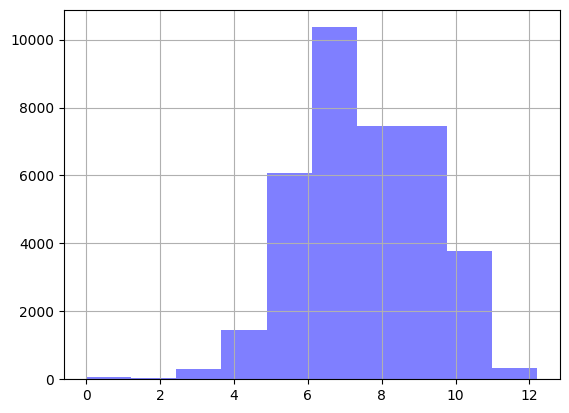

In [116]:
new_df3[new_df3['Label'] ==0]['Euclidean'].hist(color = 'r')
new_df3[new_df3['Label'] ==1]['Euclidean'].hist(color = 'b', alpha = 0.5)

In [117]:
similar_pairs = new_df3[new_df3['Label'] == 0]
dissimilar_pairs = new_df3[new_df3['Label'] == 1]

# Step 2: Downsample dissimilar pairs
downsampled_dissimilar_pairs = dissimilar_pairs.sample(n=len(similar_pairs), replace=False)

# Step 3: Combine balanced pairs
balanced_df = pd.concat([similar_pairs, downsampled_dissimilar_pairs])

# Step 4: Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [118]:
balanced_df['Label'].value_counts()

Label
1    85
0    85
Name: count, dtype: int64

In [119]:
from sklearn.model_selection import train_test_split
#from kennard_stone import train_test_split

from torch.utils.data import Dataset, DataLoader

In [121]:
X_train, X_test, y_train, y_test  = train_test_split(balanced_df[['Target', 	'Analogue','target_smi', 'analogue_smi', 'Label', 'Euclidean']], balanced_df['Label'], stratify = balanced_df['Label'], random_state = 42,test_size=0.2)

In [122]:
y_train.value_counts(normalize = False)

Label
0    68
1    68
Name: count, dtype: int64

In [123]:
y_test.value_counts(normalize = True)

Label
0    0.5
1    0.5
Name: proportion, dtype: float64

In [124]:
train_df = pd.concat([X_train,y_train], axis = 1)

In [125]:
duplicated_columns = train_df.columns[train_df.columns.duplicated()]
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
train_df

,Target,Analogue,target_smi,analogue_smi,Label,Euclidean
19539,DTXSID7061516,DTXSID801014830,[Cu++].CCCCCCCC\C=C/CCCCCCCC([O-])=O.CCCCCCCC\...,[Cr+3].CCCCCCCC\C=C\CCCCCCCC([O-])=O.CCCCCCCC\...,0,1.414214
47628,DTXSID00598114,DTXSID70705297,CCC[C@H]1CC[C@@H](CC1)C1=C(F)C(F)=C(OCC)C=C1,[H][C@@]1(CC[C@H](CCCC)CC1)[C@@]1([H])CC[C@@H]...,0,4.472136
47944,DTXSID6070510,DTXSID0027644,CC(=C)C(=O)OCCN(C)S(=O)(=O)C(F)(F)C(F)(F)C(F)(...,CCCCCCCCC=CCCCCCCCCNCCCN,1,8.717798
9175,DTXSID9070876,DTXSID8066000,CC([O-])=O.CN(C)C1=CC=C(C=C1)C(C1=CC=C(C=C1)N(...,OS([O-])(=O)=O.CN(C)C1=CC=C(C=C1)C(C1=CC=CC=C1...,0,4.123106
16661,DTXSID20884445,DTXSID901015281,CCCCCCCCCCCCCCCCCCNC(=O)CCCCCCCCCCC\C=C/CCCCCCCC,CCCCCCCC\C=C/CCCCCCCCNC(=O)CCCCCCC\C=C/CCCCCCCC,0,0.000000
...,...,...,...,...,...,...
15127,DTXSID9052214,DTXSID9042178,CCCCCCC(O)CCCCCCCCCCC(=O)NCCCCCCNC(=O)CCCCCCCC...,CCCCCCCCCCCCCCCCCC(=O)NCCO,0,5.000000
19829,DTXSID9047049,DTXSID40893650,CC(C)=CCCC(C)=CCCC(=C)C=C,[H][C@@]1(CC[C@H](CCC)CC1)[C@@]1([H])CC[C@@H](...,1,7.615773
31713,DTXSID0051863,DTXSID80904370,CC(=O)CC(C)=O,[Ni++].CC(=O)[CH-]C(C)=O.CC(=O)[CH-]C(C)=O,0,3.316625
8999,DTXSID6022977,DTXSID5030955,OC(=O)CN(CC(O)=O)CCN(CC(O)=O)CC(O)=O,CC1(C)C2CCC1(C)C(=O)C2,1,6.244998


In [128]:
duplicated_columns = test_df.columns[test_df.columns.duplicated()]
test_df = test_df.loc[:, ~test_df.columns.duplicated()]
test_df

,Target,Analogue,target_smi,analogue_smi,Label,Euclidean
23937,DTXSID10888614,DTXSID0021961,CC1=CC=C(SC2=CC=C(C=C2)C(=O)C2=CC=CC=C2)C=C1,O=C(C1=CC=CC=C1)C1=CC=CC=C1,0,4.358899
34135,DTXSID2064365,DTXSID3068677,COC1C=CC(=CC=1N=NC1=C(O)C(=CC2=CC=CC=C21)C(=O)...,OC(=O)C1=C(O)C(N=NC2=C(Cl)C=CC(Cl)=C2)=C2C=CC=...,1,9.000000
40450,DTXSID801035785,DTXSID6061810,[H][C@@]12C[C@@H](C)[C@H](C(=O)COC(C)=O)[C@@]1...,CS(=O)(=O)OC1=CC=C(NC2=C3C(=O)C4=C(C=CC=C4)C(=...,1,10.723805
33583,DTXSID70893643,DTXSID0052093,CC(=O)O[C@H]1CC[C@H](CC1)C(C)(C)C,CC(C)(C)C1CCC(CC1)OC(Cl)=O,0,3.605551
36965,DTXSID501015491,DTXSID7044972,CC(=C)C(=O)OCCCCCCCCCCCCOC(=O)C(C)=C,CC(=C)C(=O)OCCCCCCCCCCOC(=O)C(C)=C,0,0.000000
499,DTXSID50889443,DTXSID30952962,[NH4+].[NH4+].[O-]C(=O)C([O-])=O,[Cr+3].[Cr+3].[O-]C(=O)C([O-])=O.[O-]C(=O)C([O...,0,1.414214
9487,DTXSID4051744,DTXSID80338151,C1=CC(C=CC2C=CC(=CC=2)C2=NC3C=CC=CC=3O2)=CC=C1...,CN1CCN(C)CCN(C)CC1,1,7.000000
13533,DTXSID901014788,DTXSID40904295,Cl[Ni++]Cl.C1=CC=C(C=C1)P(C1=CC=CC=C1)C1=CC=CC...,[Rh+][H].[C-]#[O+].C1=CC=C(C=C1)P(C1=CC=CC=C1)...,0,2.828427
52850,DTXSID10223506,DTXSID4026921,CC(=C)C(=O)OCCOCCOCCCC,CCCCCCOCCOCCO,1,5.477226
50327,DTXSID601014777,DTXSID2049684,CC(=O)CC(C)=O,CCOC1=CC2C=CC=CC=2C=C1,1,6.082763


In [127]:
test_df = pd.concat([X_test,y_test], axis = 1)

In [129]:
test_df

,Target,Analogue,target_smi,analogue_smi,Label,Euclidean
23937,DTXSID10888614,DTXSID0021961,CC1=CC=C(SC2=CC=C(C=C2)C(=O)C2=CC=CC=C2)C=C1,O=C(C1=CC=CC=C1)C1=CC=CC=C1,0,4.358899
34135,DTXSID2064365,DTXSID3068677,COC1C=CC(=CC=1N=NC1=C(O)C(=CC2=CC=CC=C21)C(=O)...,OC(=O)C1=C(O)C(N=NC2=C(Cl)C=CC(Cl)=C2)=C2C=CC=...,1,9.000000
40450,DTXSID801035785,DTXSID6061810,[H][C@@]12C[C@@H](C)[C@H](C(=O)COC(C)=O)[C@@]1...,CS(=O)(=O)OC1=CC=C(NC2=C3C(=O)C4=C(C=CC=C4)C(=...,1,10.723805
33583,DTXSID70893643,DTXSID0052093,CC(=O)O[C@H]1CC[C@H](CC1)C(C)(C)C,CC(C)(C)C1CCC(CC1)OC(Cl)=O,0,3.605551
36965,DTXSID501015491,DTXSID7044972,CC(=C)C(=O)OCCCCCCCCCCCCOC(=O)C(C)=C,CC(=C)C(=O)OCCCCCCCCCCOC(=O)C(C)=C,0,0.000000
499,DTXSID50889443,DTXSID30952962,[NH4+].[NH4+].[O-]C(=O)C([O-])=O,[Cr+3].[Cr+3].[O-]C(=O)C([O-])=O.[O-]C(=O)C([O...,0,1.414214
9487,DTXSID4051744,DTXSID80338151,C1=CC(C=CC2C=CC(=CC=2)C2=NC3C=CC=CC=3O2)=CC=C1...,CN1CCN(C)CCN(C)CC1,1,7.000000
13533,DTXSID901014788,DTXSID40904295,Cl[Ni++]Cl.C1=CC=C(C=C1)P(C1=CC=CC=C1)C1=CC=CC...,[Rh+][H].[C-]#[O+].C1=CC=C(C=C1)P(C1=CC=CC=C1)...,0,2.828427
52850,DTXSID10223506,DTXSID4026921,CC(=C)C(=O)OCCOCCOCCCC,CCCCCCOCCOCCO,1,5.477226
50327,DTXSID601014777,DTXSID2049684,CC(=O)CC(C)=O,CCOC1=CC2C=CC=CC=2C=C1,1,6.082763


<Axes: >

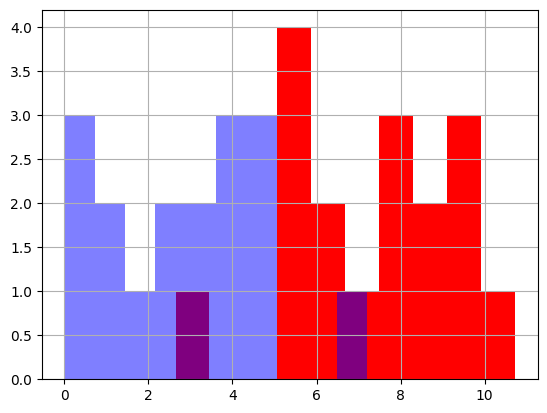

In [131]:
test_df[test_df['Label']==1]['Euclidean'].hist(color = 'r')
test_df[test_df['Label']==0]['Euclidean'].hist(color = 'b', alpha = 0.5)

Text(0, 0.5, 'Number of test set chemical pairs')

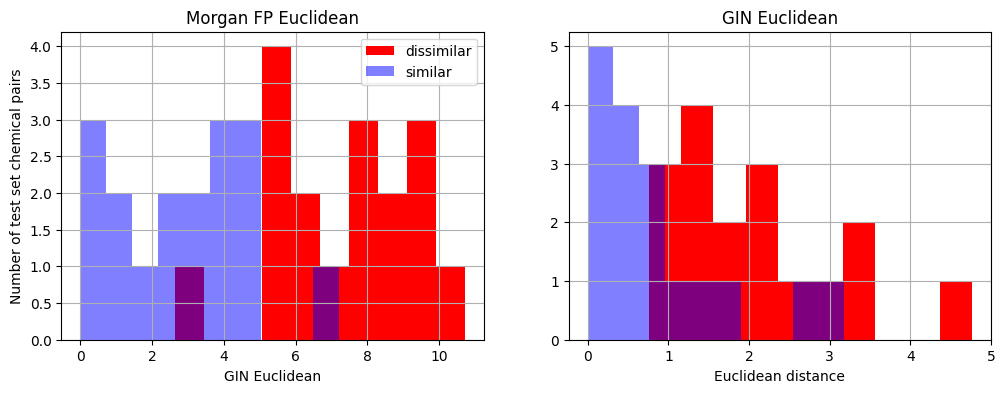

In [186]:
f, axes = plt.subplots(1,2, figsize = (12,4))
test_df[test_df['Label']==1]['euclidean'].hist(color = 'r', ax=axes[1], label = 'dissimilar')
test_df[test_df['Label']==0]['euclidean'].hist(color = 'b', alpha = 0.5, ax=axes[1], label = 'similar')
test_df[test_df['Label']==1]['Euclidean'].hist(color = 'r', ax=axes[0], label = 'dissimilar')
test_df[test_df['Label']==0]['Euclidean'].hist(color = 'b', alpha = 0.5, ax = axes[0], label = 'similar')
axes[0].set_xlabel('GIN Euclidean')
axes[0].set_title('Morgan FP Euclidean')
axes[0].legend()

axes[1].set_title('GIN Euclidean')
axes[1].set_xlabel('Euclidean distance')
axes[0].set_ylabel('Number of test set chemical pairs')
#axes[1].legend()
#f.savefig('testset_SS.png', dpi = 300, bbox_inches = 'tight')

In [187]:
train_df

,Target,Analogue,target_smi,analogue_smi,Label,Euclidean
19539,DTXSID7061516,DTXSID801014830,[Cu++].CCCCCCCC\C=C/CCCCCCCC([O-])=O.CCCCCCCC\...,[Cr+3].CCCCCCCC\C=C\CCCCCCCC([O-])=O.CCCCCCCC\...,0,1.414214
47628,DTXSID00598114,DTXSID70705297,CCC[C@H]1CC[C@@H](CC1)C1=C(F)C(F)=C(OCC)C=C1,[H][C@@]1(CC[C@H](CCCC)CC1)[C@@]1([H])CC[C@@H]...,0,4.472136
47944,DTXSID6070510,DTXSID0027644,CC(=C)C(=O)OCCN(C)S(=O)(=O)C(F)(F)C(F)(F)C(F)(...,CCCCCCCCC=CCCCCCCCCNCCCN,1,8.717798
9175,DTXSID9070876,DTXSID8066000,CC([O-])=O.CN(C)C1=CC=C(C=C1)C(C1=CC=C(C=C1)N(...,OS([O-])(=O)=O.CN(C)C1=CC=C(C=C1)C(C1=CC=CC=C1...,0,4.123106
16661,DTXSID20884445,DTXSID901015281,CCCCCCCCCCCCCCCCCCNC(=O)CCCCCCCCCCC\C=C/CCCCCCCC,CCCCCCCC\C=C/CCCCCCCCNC(=O)CCCCCCC\C=C/CCCCCCCC,0,0.000000
...,...,...,...,...,...,...
15127,DTXSID9052214,DTXSID9042178,CCCCCCC(O)CCCCCCCCCCC(=O)NCCCCCCNC(=O)CCCCCCCC...,CCCCCCCCCCCCCCCCCC(=O)NCCO,0,5.000000
19829,DTXSID9047049,DTXSID40893650,CC(C)=CCCC(C)=CCCC(=C)C=C,[H][C@@]1(CC[C@H](CCC)CC1)[C@@]1([H])CC[C@@H](...,1,7.615773
31713,DTXSID0051863,DTXSID80904370,CC(=O)CC(C)=O,[Ni++].CC(=O)[CH-]C(C)=O.CC(=O)[CH-]C(C)=O,0,3.316625
8999,DTXSID6022977,DTXSID5030955,OC(=O)CN(CC(O)=O)CCN(CC(O)=O)CC(O)=O,CC1(C)C2CCC1(C)C(=O)C2,1,6.244998


In [132]:
from torch_geometric.utils import smiles as pygsmi
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.loader import DataLoader

In [133]:


target_X = [pygsmi.from_smiles(m) for m in X_train['target_smi']]

In [134]:
analogue_X = [pygsmi.from_smiles(m) for m in X_train['analogue_smi']]

In [135]:
class GraphData(Dataset):
    def __init__(self, df):
        """
        GraphData class inheriting from the Dataset class in PyTorch.

        Parameters
        ----------
    
        node_vec_len : int
            Node vector length of molecular graphs
        max_atoms : int
            Maximum number of atoms in molecular graphs
        """
        self.df = df

        # Create lists
        #self.indices = df.index.to_list()
        #self.smiles = df["smiles"].to_list()
        #self.outputs = df["measured log solubility in mols per litre"].to_list()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        """
        Returns node matrix, adjacency matrix, output, and SMILES string of
        molecule.

        Parameters
        ----------
        i : int
            Dataset index

        Returns
        -------
        node_mat : torch.Tensor with dimension (max_atoms,node_vec_len)
            Node matrix
        adj_mat: torch.Tensor with dimension (max_atoms,max_atoms)
            Adjacency matrix
        output : torch.Tensor with dimension n_outputs
            Output vector
        smile : str
            SMILES string of molecule
        """
        
        row = self.df.iloc[idx]
        target = pygsmi.from_smiles(row['target_smi'])
        analogue =pygsmi.from_smiles(row['analogue_smi'])
        target.x = target.x.float()
        analogue.x = analogue.x.float()


        # Get output
        label = torch.tensor(row['Label'], dtype=torch.long)

        return target, analogue, label

   

In [136]:
train_data = GraphData(X_train)

In [137]:
train_data[0][0].num_features

9

In [138]:
test_data = GraphData(X_test)

In [139]:
train_data[0][0].num_features

9

In [140]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

In [141]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(9, 3)
        self.out = Linear(3, 1)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

In [164]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(9, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
      #  self.conv2 = GINConv(
        #    Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
       #                Linear(dim_h, dim_h), ReLU()))
        #self.conv3 = GINConv(
      #      Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
      #                 Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        #self.lin2 = Linear(dim_h*3, 1)

    def forward_once(self, data, batch=torch.tensor([0])):
        x, edge_index = data.x, data.edge_index
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        #h2 = self.conv2(h1, edge_index)
        #h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        #h1 = global_add_pool(h1, batch)
        #h2 = global_add_pool(h2, batch)
        #h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        #h = torch.cat((h1, h2, h3), dim=1)
        
        h = global_add_pool(h1, batch)
        # Classifier
        #h = self.lin1(h)
        #h = h.relu()
        #h = F.dropout(h, p=0.5, training=self.training)
        #h = self.lin2(h)
        
        return h
       
        
    def forward(self, input1, input2):
       
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
    
    

In [165]:
gin = GIN(dim_h=32)


In [166]:
'''n_features = 9
# definenet
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(n_features, 128, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(128)
        self.conv2 = GCNConv(128, 64, cached=False)
        self.bn2 = BatchNorm1d(64)
        self.fc1 = Linear(64, 64)
        self.bn3 = BatchNorm1d(64)
        self.fc2 = Linear(64, 64)
        self.fc3 = Linear(64, 1)
         
    def forward_once(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)
        #x = F.log_softmax(x, dim=1)
        
        return x
        
        
    def forward(self, input1, input2):
       
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
       
    

SyntaxError: EOF while scanning triple-quoted string literal (2797854401.py, line 39)

In [167]:
from torch_geometric.nn.models import GAT, GIN
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool


In [168]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Euclidean distance between the embeddings
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        # Contrastive loss formula
        contrastive_loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return contrastive_loss

In [169]:
#model = SN(hidden_channels = 64, num_layers = 1, dropout= 0, pooling_type = 'max', out_channels = 1 , in_channels = 9)

In [170]:
criterion = ContrastiveLoss()
#optimizer = torch.optim.SGD(params=gin.parameters(), lr=0.005)

optimizer = torch.optim.Adam(gin.parameters(), lr=0.0005)

In [171]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, drop_last=True)

In [172]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=True)

In [173]:
#model = torch_geometric.compile(model)

In [174]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
     

In [175]:
def train_siamese_network(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    iteration_number= 0
    counter = []
    loss_history = [] 
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, data in enumerate(train_loader,0):
            input1, input2, label = data
            optimizer.zero_grad()
            output1, output2 = model(input1, input2)
            loss = criterion(output1, output2, label)
            #print(loss)
            total_loss += loss /len(train_loader)
            loss.backward()
            optimizer.step()
            iteration_number += 1
            counter.append(iteration_number)
            loss_history.append(loss.item())
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {total_loss / len(train_loader)}")
    show_plot(counter, loss_history)


In [176]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [177]:
def test_network(model, test_loader, threshold=5):
    model.eval()
    true_l = []
    predicted_l = []
    euclidean = []
    with torch.no_grad():
         for i, data in enumerate(test_loader):
            # Unpack data
            input1, input2, label = data
            
            
            output1, output2 = model(input1, input2)
            #print(output1, output2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            
            predictions = (euclidean_distance < threshold).float()

            true_l.extend(label.view(-1).cpu().numpy())
            predicted_l.extend(predictions.view(-1).cpu().numpy())
            euclidean.extend(euclidean_distance.view(-1).cpu().numpy())
    
    # Convert lists to numpy arrays
    
    true_labels = np.array(true_l)
    predicted_labels = np.array(predicted_l)
    print(len(true_labels),len(predicted_labels), len(predicted_l))
            
            #true_labels = np.array(true_labels)
            #predicted_labels= np.concatenate(predicted_labels, axis=0).flatten()
    #print(len(predicted_labels))
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return true_labels, predicted_labels, euclidean

Epoch [1/10] Loss: 0.20354239642620087
Epoch [2/10] Loss: 0.06574954837560654
Epoch [3/10] Loss: 0.02375541441142559
Epoch [4/10] Loss: 0.010940628126263618
Epoch [5/10] Loss: 0.006827349774539471
Epoch [6/10] Loss: 0.005257644224911928
Epoch [7/10] Loss: 0.0045767296105623245
Epoch [8/10] Loss: 0.004149665590375662
Epoch [9/10] Loss: 0.00390941696241498
Epoch [10/10] Loss: 0.003828112268820405


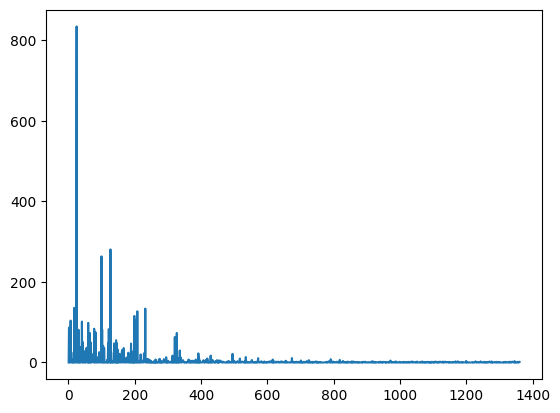

In [178]:
train_siamese_network(gin, train_loader, optimizer, criterion, num_epochs=10)

In [193]:
a,b,c = test_network(gin, test_loader, threshold = 2.5)

34 34 34
Accuracy: 0.4118
Precision: 0.4444
Recall: 0.7059
F1 Score: 0.5455


In [205]:
b

array([1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [194]:
test_df['euclidean'] = c

In [195]:
test_df['label'] = a

In [196]:
test_df.head()

,Target,Analogue,target_smi,analogue_smi,Label,Euclidean,euclidean,label
23937,DTXSID10888614,DTXSID0021961,CC1=CC=C(SC2=CC=C(C=C2)C(=O)C2=CC=CC=C2)C=C1,O=C(C1=CC=CC=C1)C1=CC=CC=C1,0,4.358899,1.348489,0
34135,DTXSID2064365,DTXSID3068677,COC1C=CC(=CC=1N=NC1=C(O)C(=CC2=CC=CC=C21)C(=O)...,OC(=O)C1=C(O)C(N=NC2=C(Cl)C=CC(Cl)=C2)=C2C=CC=...,1,9.000000,1.727584,1
40450,DTXSID801035785,DTXSID6061810,[H][C@@]12C[C@@H](C)[C@H](C(=O)COC(C)=O)[C@@]1...,CS(=O)(=O)OC1=CC=C(NC2=C3C(=O)C4=C(C=CC=C4)C(=...,1,10.723805,4.765681,1
33583,DTXSID70893643,DTXSID0052093,CC(=O)O[C@H]1CC[C@H](CC1)C(C)(C)C,CC(C)(C)C1CCC(CC1)OC(Cl)=O,0,3.605551,1.720306,0
36965,DTXSID501015491,DTXSID7044972,CC(=C)C(=O)OCCCCCCCCCCCCOC(=O)C(C)=C,CC(=C)C(=O)OCCCCCCCCCCOC(=O)C(C)=C,0,0.000000,0.166468,0


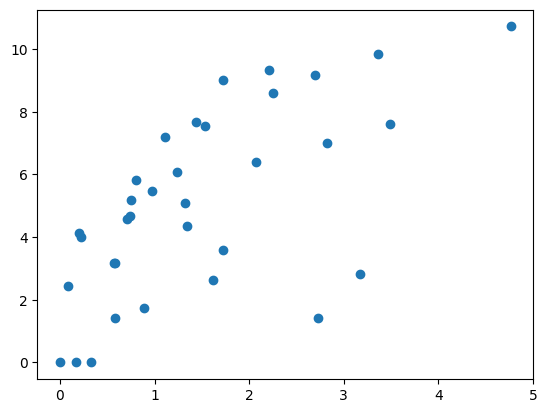

In [190]:
plt.plot(test_df['euclidean'], test_df['Euclidean'], marker = 'o', linestyle = 'None')

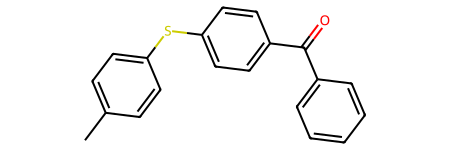

In [183]:
Chem.MolFromSmiles(test_df['target_smi'].values[0])

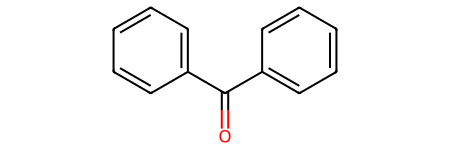

In [184]:
Chem.MolFromSmiles(test_df['analogue_smi'].values[0])

In [197]:
train_results = test_network(gin, train_loader, threshold = 2.5)

136 136 136
Accuracy: 0.2721
Precision: 0.3524
Recall: 0.5441
F1 Score: 0.4277


In [201]:
from sklearn.metrics import balanced_accuracy_score,accuracy_score,f1_score, confusion_matrix, classification_report


In [206]:
confusion_matrix(a, b)

array([[ 2, 15],
       [ 5, 12]])